<a href="https://colab.research.google.com/github/edsonportosilva/OpticalCommunications/blob/main/jupyter notebooks/8. Introdução às comunicações ópticas coerentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install .

In [106]:
import matplotlib.pyplot as plt
import numpy as np
from optic.comm.modulation import modulateGray, demodulateGray, grayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample, decimate
from optic.comm.metrics import signal_power
from optic.plot import eyediagram
from optic.utils import parameters, dBm2W
from optic.models.devices import iqm, coherentReceiver, pdmCoherentReceiver
from optic.models.channels import linearFiberChannel
from optic.dsp.equalization import edc, mimoAdaptEqualizer
from optic.plot import pconst

import logging as logg
logg.basicConfig(level=logg.INFO, format='%(message)s', force=True)

In [107]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [108]:
%matplotlib inline
#figsize(7, 2.5)
figsize(10, 3)

In [109]:
import sympy as sp
from utils import symdisp, symplot

# Equalização em sistemas ópticos coerentes

O algoritmo de equalização adaptativa **LMS (Least Mean Squares)** é amplamente usado em comunicações digitais para ajustar os coeficientes de um filtro linear com base na minimização do erro médio quadrático entre a saída do filtro e uma sequência de treinamento conhecida.

Considere que desejamos filtrar uma sequência de amostras de sinal $x[n]$ com um filtro FIR cujos coeficientes são representados pelo vetor $\mathbf{w}$. A saída do filtro no instante $n$ é dada por:
$$
y[n] = \mathbf{w}^H \mathbf{x}[n]
$$
onde:
- $ \mathbf{w} $ é o vetor de coeficientes do filtro adaptativo ($M \times 1$);
- $ \mathbf{x}[n] $ é o vetor de amostras de entrada ($M \times 1$);
- $ (\cdot)^H $ representa a transposta conjugada.

### Critério de erro (função custo LMS)

A função objetivo no LMS é a minimização do **erro médio quadrático (MSE)**, definido como:
$$
J(\mathbf{w}) = \mathbb{E}[|e[n]|^2],
$$
onde:
- $ e[n] = d[n] - \mathbf{w}^H \mathbf{x}[n] $ é o erro instantâneo;
- $ \mathbb{E}[\cdot] $ representa o valor esperado.

Substituindo $ e[n] $ na função objetivo:
$$
J(\mathbf{w}) = \mathbb{E}\left[|d[n] - \mathbf{w}^H \mathbf{x}[n]|^2\right].
$$

Para atualizar os coeficientes do filtro usando o gradiente descendente, calculamos a derivada de $ J(\mathbf{w}) $ em relação a $ \mathbf{w} $ (o conjugado):
$$
\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}} = -\mathbb{E}\left[e^*[n] \, \mathbf{x}[n]\right].
$$

Esse processo busca minimizar $ J(\mathbf{w}) $ iterativamente, reduzindo o erro médio quadrático.


### Erro instantâneo
O erro instantâneo é a diferença entre a saída desejada e a saída do filtro:
$$
e_{LMS}[n] = d[n] - y[n],
$$
onde:
- $ d[n] $ é a amostra da sequência de treinamento (sinal desejado);
- $ y[n] $ é a saída do filtro.


### Atualização dos coeficientes do filtro
O LMS utiliza o **gradiente descendente estocástico** para minimizar o erro médio quadrático:
$$
\mathbf{w}[n+1] = \mathbf{w}[n] + \mu e_{LMS}^*[n] \mathbf{x}[n],
$$
onde:
- $ \mu $ é o passo de adaptação (também chamado de taxa de aprendizado);
- $ e[n] $ é o erro instantâneo.


O LMS é eficiente, de baixa complexidade e muito utilizado em sistemas onde uma sequência de treinamento é disponível.


## Constant Modulus Algorithm (CMA)

Dentre os algoritmos de equalização adaptativa utilizados em receptores ópticos coerentes, o algoritmo **CMA (Constant Modulus Algorithm)** é um dos mais populares, uma vez que o mesmo pode ser utilizado para equalização adaptativa de sinais e para separar sinais multiplexados em diferentes estados de polarização.

O CMA é um algoritmo de filtragem adaptativa. Diferentemente do LMS, o CMA não requer o uso de sequências de treinamento. Nos métodos cegos de filtragem adaptativa, como o CMA, utiliza-se um algoritmo gradiente estocástico para encontrar adaptativamente os coeficientes do filtro buscando minimizar uma função objetivo baseadas em critérios estatísticos vinculados à características dos sinais filtrados.

Por exemplo, em modulações PSK, todos os símbolos transmitidos possuem a mesma potência, ou seja, módulo constante. Isso torna o CMA particularmente adequado para equalização adaptativa de modulações PSK.

A ideia central do CMA é ajustar iterativamente os coeficientes do filtro adaptativo de forma que a saída do equalizador tenha um módulo constante, independentemente da fase.

Considerando que a saída do filtro é dada por:
$$
y[n] = \mathbf{w}^H \mathbf{x}[n]
$$
onde:
- $ \mathbf{w} $ é o vetor de coeficientes do filtro adaptativo ($M \times 1$);
- $ \mathbf{x}[n] $ é o vetor de amostras de entrada ($M \times 1$);
- $ (\cdot)^H $ representa a transposto conjugado.

### Critério de erro (função custo CMA)
O objetivo do algoritmo CMA é minimizar o seguinte critério de custo:
$$
J(\mathbf{w}) = \mathbb{E}\left[\left(|y[n]|^2 - R_d\right)^2\right],
$$
onde:
- $ |y[n]|^2 $ é a magnitude da saída do filtro;
- $ R_d $ é o módulo desejado, geralmente calculado como $ R_d = \frac{\mathbb{E}[|s[n]|^4]}{\mathbb{E}[|s[n]|^2]} $, sendo $ s[n] $ o sinal transmitido.

O erro instantâneo é dado por:
$$
e_{CMA}[n] = |y[n]|^2 - R_d,
$$
que mede a diferença entre o módulo ao quadrado da saída do filtro e o módulo desejado.


### Atualização dos coeficientes do filtro
O CMA utiliza o **gradiente descendente estocástico** para atualizar os coeficientes do filtro:
$$
\mathbf{w}[n+1] = \mathbf{w}[n] - \mu \frac{\partial J}{\partial \mathbf{w}},
$$
onde:
- $ \mu $ é o passo de adaptação;
- $ \frac{\partial J}{\partial \mathbf{w}} $ é o gradiente do custo em relação ao vetor de coeficientes do filtro $ \mathbf{w}$.

Derivando $ J(\mathbf{w}) $, temos:
$$
\frac{\partial J}{\partial \mathbf{w}} = e_{CMA}[n] y^*[n] \mathbf{x}[n].
$$

Portanto, a equação de atualização torna-se:
$$
\mathbf{w}[n+1] = \mathbf{w}[n] - \mu e_{CMA}[n] \, y^*[n] \mathbf{x}[n],
$$
ou, explicitamente:
$$
\mathbf{w}[n+1] = \mathbf{w}[n] - \mu (|y[n]|^2 - R_d) y^*[n]\mathbf{x}[n].
$$

### Exemplo: simulação de transmissão QPSK

<img src="./figuras/sistemaCoerente.png" width="1000">

In [110]:
# parâmetros da simulação
M = 4               # ordem da modulação
constType = 'qam'   # tipo de modulação
SpS = 16            # Amostras por símbolo
Rs  = 10e9          # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fs  = SpS*Rs        # Frequência de amostragem do sinal (amostras/segundo)

# parâmetros do IQM
paramIQM = parameters()
paramIQM.Vpi = 2 
paramIQM.Vb = -paramIQM.Vpi

Pi_dBm = 10 # potência de sinal óptico na entrada do modulador em dBm 
Pi = dBm2W(Pi_dBm) # potência de sinal óptico em W na entrada do MZM

# parâmetros do receptor
B   = 10e9      # banda do receptor em Hz
Plo_dBm  = 10   # potência do oscilador local
Δf_lo = 0       # desvio de frequência do oscilador local
ϕ_lo  = 0       # fase do oscilador local

Plo = dBm2W(Plo_dBm) # potência do oscilador local na entrada do receptor

# Parâmetros da fibra
paramFiber = parameters()
paramFiber.L = 200        # comprimento do enlace [km]
paramFiber.alpha = 0.2      # coeficiente de perdas [dB/Km]
paramFiber.D = 17           # parâmetro de dispersão [ps/nm/km]
paramFiber.Fs = Fs          # Frequência de amostragem do sinal [amostras/segundo]
paramFiber.Fc = 193.1e12    # Hz

# Taxa de amostragem do ADC
paramADC = parameters()
paramADC.Rs = Rs
paramADC.SpS_in = SpS
paramADC.SpS_out = 2

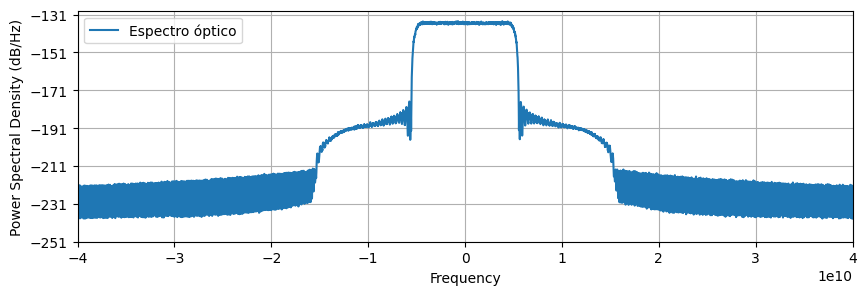

In [111]:
############# Simulação #############

### Transmissor

# gera sequência pseudo-aleatória de bits
bitsTx = np.random.randint(2, size = int(2e5*np.log2(M)))

# mapeia bits para símbolos da constelação
symbTx = modulateGray(bitsTx, M, constType)    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso
pulse = pulseShape('rrc', SpS)

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = sigTx/np.max(np.abs(sigTx.real)) # ajusta amplitudes do sinal para variar entre -1 e 1

# modulação óptica
Ai = np.sqrt(Pi)
sigTxo = iqm(Ai, 0.25*paramIQM.Vpi*sigTx, paramIQM)

# canal óptico linear
sigRxo = linearFiberChannel(sigTxo, paramFiber)

# plota psd
plt.figure();
plt.psd(sigTxo,Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'Espectro óptico')
plt.legend(loc='upper left');
plt.xlim(-4*Rs,4*Rs);

### Recepcão coerente

# oscilador local
π = np.pi
t     = np.arange(0, sigTxo.size)*(1/Fs)
sigLO = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo))

# receptor coerente
sigRx = coherentReceiver(sigRxo, sigLO)
sigRx = pnorm(sigRx)

sigRx = firFilter(pulse, sigRx)

# captura amostras no meio dos intervalos de sinalização
paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = 1
sigRx = decimate(sigRx.reshape(-1,1), paramDec).reshape(-1,)
sigRx = pnorm(sigRx)

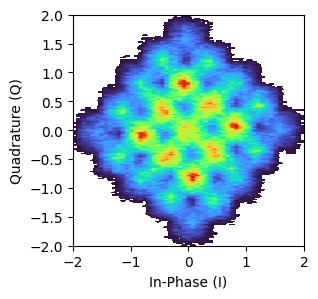

In [112]:
pconst(sigRx, R=2);

## Equalização adaptativa com LMS

Running adaptive equalizer...
nlms - training stage #0
nlms pre-convergence training iteration #0
nlms MSE = 0.133191.
nlms pre-convergence training iteration #1
nlms MSE = 0.004928.
nlms pre-convergence training iteration #2
nlms MSE = 0.004588.
nlms pre-convergence training iteration #3
nlms MSE = 0.004589.
nlms pre-convergence training iteration #4
nlms MSE = 0.004589.
nlms - training stage #1
nlms MSE = 0.004462.


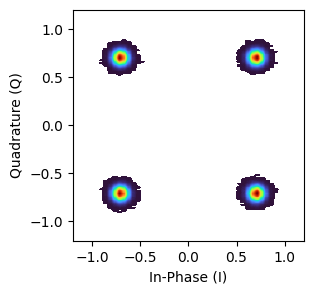

In [113]:
# parâmetros do equalizador adaptativo
paramEq.nTaps = 7
paramEq.SpS = 1
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.M = M
paramEq.L = [int(0.1*sigRx.shape[0]), int(0.9*sigRx.shape[0])]
paramEq.prgsBar = False
paramEq.alg = ['nlms','nlms'] # QPSK
paramEq.mu = [1e-3, 1e-3]
    
outEq = mimoAdaptEqualizer(sigRx, paramEq, symbTx)
outEq = pnorm(outEq)

discard = 1000
pconst(outEq[discard:-discard], R=1.2);

## Equalização adaptativa com CMA

Running adaptive equalizer...
cma - training stage #0
cma pre-convergence training iteration #0
cma MSE = 0.238851.
cma pre-convergence training iteration #1
cma MSE = 0.034409.
cma pre-convergence training iteration #2
cma MSE = 0.009532.
cma pre-convergence training iteration #3
cma MSE = 0.008964.
cma pre-convergence training iteration #4
cma MSE = 0.008954.
cma - training stage #1
cma MSE = 0.008878.


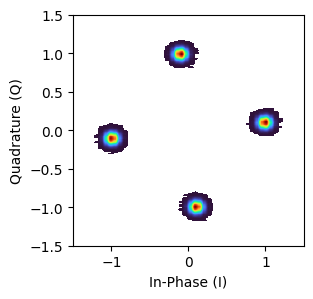

In [114]:
# parâmetros do equalizador adaptativo
paramEq.nTaps = 7
paramEq.SpS = 1
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.M = M
paramEq.L = [int(0.1*sigRx.shape[0]), int(0.9*sigRx.shape[0])]
paramEq.prgsBar = False
paramEq.alg = ['cma','cma'] # QPSK
paramEq.mu = [1e-4, 1e-3]
    
outEq = mimoAdaptEqualizer(sigRx, paramEq, symbTx)

discard = 1000
pconst(outEq[discard:-discard], R=1.5);

## Sistemas com multiplexação de polarização

<img src="./figuras/sistemaCoerentePM.png" width="900">

In [126]:
############# Simulação #############

### Transmissor

# gera sequência pseudo-aleatória de bits
bitsX = np.random.randint(2, size = int(2e5*np.log2(M)))
bitsY = np.random.randint(2, size = int(2e5*np.log2(M)))

# mapeia bits para símbolos da constelação
symbX = modulateGray(bitsX, M, constType)    
symbX = pnorm(symbX) # power normalization

symbY = modulateGray(bitsY, M, constType)    
symbY = pnorm(symbY) # power normalization

symbTx = np.column_stack((symbX, symbY))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso
pulse = pulseShape('rrc', SpS)

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = pnorm(sigTx)

# modulação óptica
Ai = np.sqrt(Pi)
sigTxo = iqm(Ai, 0.25*paramIQM.Vpi*sigTx, paramIQM)

# canal óptico linear
sigRxo = linearFiberChannel(sigTxo, paramFiber)

### Recepcão coerente

# oscilador local
π = np.pi
t     = np.arange(0, sigTxo.shape[0])*(1/Fs)
sigLO = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo))

# receptor coerente com diversidade de polarização
θsig = π/3 # polarization rotation angle
sigRx = pdmCoherentReceiver(sigRxo, sigLO, θsig)
sigRx = pnorm(sigRx)

sigRx = firFilter(pulse, sigRx)

# captura amostras no meio dos intervalos de sinalização
paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = 1
sigRx = decimate(sigRx, paramDec)
sigRx = pnorm(sigRx)

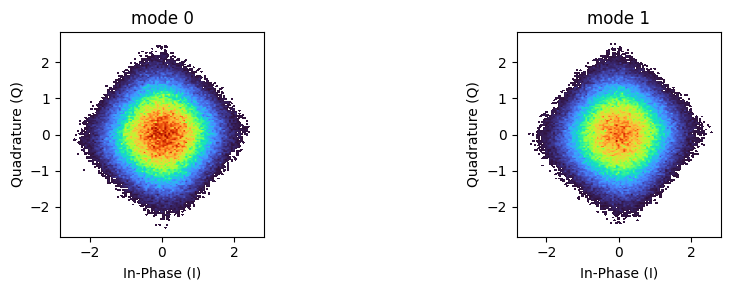

In [127]:
pconst(sigRx, R=2);

## Separação de polarizações e equalização adaptativa com LMS

Running adaptive equalizer...
nlms - training stage #0
nlms pre-convergence training iteration #0
nlms MSE = 0.349653.
nlms pre-convergence training iteration #1
nlms MSE = 0.005680.
nlms pre-convergence training iteration #2
nlms MSE = 0.004598.
nlms pre-convergence training iteration #3
nlms MSE = 0.004595.
nlms pre-convergence training iteration #4
nlms MSE = 0.004595.
nlms - training stage #1
nlms MSE = 0.004483.


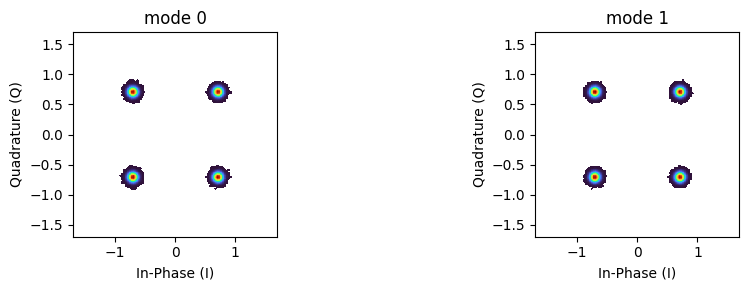

In [128]:
# parâmetros do equalizador adaptativo
paramEq.nTaps = 7
paramEq.SpS = 1
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.M = M
paramEq.L = [int(0.1*sigRx.shape[0]), int(0.9*sigRx.shape[0])]
paramEq.prgsBar = False
paramEq.alg = ['nlms','nlms'] # QPSK
paramEq.mu = [1e-3, 1e-3]
    
outEq = mimoAdaptEqualizer(sigRx, paramEq, symbTx)
outEq = pnorm(outEq)

discard = 1000
pconst(outEq[discard:-discard,:], R=1.2);

## Separação de polarizações e equalização adaptativa com CMA

Running adaptive equalizer...
cma - training stage #0
cma pre-convergence training iteration #0
cma MSE = 0.367177.
cma pre-convergence training iteration #1
cma MSE = 0.117890.
cma pre-convergence training iteration #2
cma MSE = 0.014520.
cma pre-convergence training iteration #3
cma MSE = 0.009117.
cma pre-convergence training iteration #4
cma MSE = 0.009007.
cma - training stage #1
cma MSE = 0.008978.


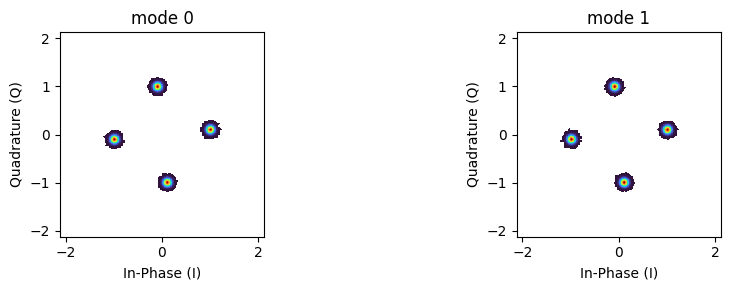

In [129]:
# parâmetros do equalizador adaptativo
paramEq.nTaps = 7
paramEq.SpS = 1
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.M = M
paramEq.L = [int(0.1*sigRx.shape[0]), int(0.9*sigRx.shape[0])]
paramEq.prgsBar = False
paramEq.alg = ['cma','cma'] # QPSK
paramEq.mu = [1e-4, 1e-3]
    
outEq = mimoAdaptEqualizer(sigRx, paramEq, symbTx)

discard = 1000
pconst(outEq[discard:-discard], R=1.5);